In [41]:
import os
import hdf5storage
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, GRU, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

from scipy.stats import entropy

In [2]:
# Load data

data_folders = ['./Data']

dfs = []
for data_folder in data_folders:
    mat_files = [f for f in os.listdir(data_folder) if f.endswith('.mat')]
    for mat_file in mat_files:
        mat_data = hdf5storage.loadmat(os.path.join(data_folder, mat_file))
        df = pd.DataFrame(mat_data['data'])
        df = df.iloc[:, list(range(70)) + [72]]
        dfs.append(df)
all_data = pd.concat(dfs, axis=0, ignore_index=True)
y = all_data.iloc[:, -1]

In [3]:
all_data.shape

(514545, 71)

In [4]:
import os
import pandas as pd
from scipy.io import loadmat

# Assuming the 'Data' folder is in the current working directory
data_folders = ['./Data']

# Initialize lists to store the separated dataframes
protective_dfs = []
non_protective_dfs = []

# Loop through each data folder
for data_folder in data_folders:
    # List all .mat files in the current data folder
    mat_files = [f for f in os.listdir(data_folder) if f.endswith('.mat')]
    # Load each mat file
    for mat_file in mat_files:
        # Construct the full path to the .mat file
        mat_path = os.path.join(data_folder, mat_file)
        # Load the .mat file
        mat_data = loadmat(mat_path)
        # Convert the data into a pandas dataframe
        df = pd.DataFrame(mat_data['data'])
        # Select only the first 70 columns and the last column (73rd) which contains the behavior label
        df = df.iloc[:, list(range(66)) + [72]]
        # Split the data based on the protective behavior label
        # Assuming the last column in df is the protective behavior label
        protective_behavior = df.iloc[:, -1]
        protective_df = df[protective_behavior == 1]
        non_protective_df = df[protective_behavior == 0]
        # Append the resulting dataframes to their respective lists
        protective_dfs.append(protective_df)
        non_protective_dfs.append(non_protective_df)

# Concatenate all protective and non-protective dataframes
all_protective_data = pd.concat(protective_dfs, axis=0, ignore_index=True)
all_non_protective_data = pd.concat(non_protective_dfs, axis=0, ignore_index=True)

# Now `all_protective_data` and `all_non_protective_data` hold the protective and non-protective data respectively
# You can process these dataframes as needed for your analysis or save them to new .mat files
print(all_protective_data.shape)
print(all_non_protective_data.shape)

(77298, 67)
(437247, 67)


In [37]:
nodes_data = {}

# There are 22 nodes, so we loop through each
for node in range(1, 23):
    # Calculate the index for x, y, and z based on the node number
    x_index = node - 1
    y_index = x_index + 22
    z_index = x_index + 44

    # Extract the data for the current node
    node_data = all_protective_data.iloc[:, [x_index, y_index, z_index]]

    # Assign the node data to the corresponding entry in the dictionary
    nodes_data[f'node_{node}'] = node_data

# print(nodes_data[f'node_{1}'][22])

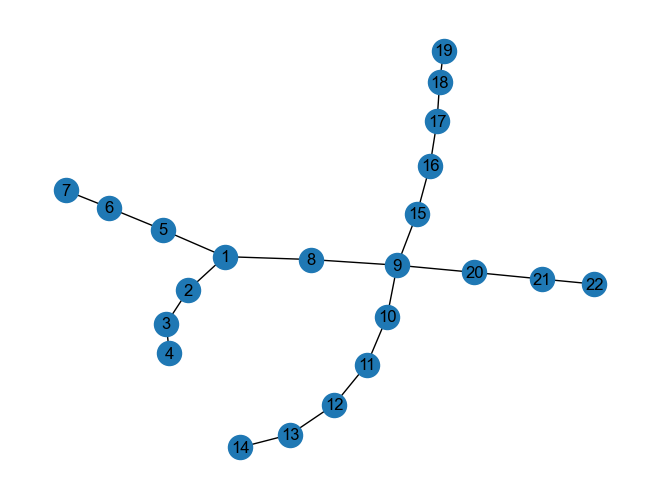

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
edges = [
    # (node_from, node_to) based on the known graph structure
    (1, 2), (1, 5), (1, 8), (2, 3), (3, 4), (5, 6), (6, 7),
    (8, 9), (9, 10), (9, 15), (9, 20), (10, 11), (11, 12),
    (12, 13), (13, 14), (15, 16), (16, 17), (17, 18), (18, 19),
    (9, 20), (20, 21), (21, 22)
]

# Initialize a Directed Graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(range(1, 23))  # Nodes 1 through 23

# Add edges as defined above
G.add_edges_from(edges)
G_undirected = G.to_undirected()

# Now G is your DAG with the structure you have defined
# Visualize the graph
nx.draw(G_undirected, with_labels=True)
plt.show()

In [49]:
node_1_x_data = nodes_data['node_1'][0].iloc[:10000]
node_1_y_data = nodes_data['node_1'][22].iloc[:10000]
node_1_z_data = nodes_data['node_1'][44].iloc[:10000]

node_2_x_data = nodes_data['node_2'][1].iloc[:10000]
node_2_y_data = nodes_data['node_2'][23].iloc[:10000]
node_2_z_data = nodes_data['node_2'][45].iloc[:10000]

df_x = pd.DataFrame({'node_1_x': node_1_x_data, 'node_2_x': node_2_x_data})
df_y = pd.DataFrame({'node_1_y': node_1_y_data, 'node_2_y': node_2_y_data})
df_z = pd.DataFrame({'node_1_z': node_1_z_data, 'node_2_z': node_2_z_data})

# 使用PC算法估计每个坐标维度的DAG结构，以X坐标为例
pc = PC(df_x)
estimated_dag_x = pc.estimate()

# 根据估计的DAG构建贝叶斯网络
bn_x = BayesianModel(estimated_dag_x.edges())

# 对X坐标的贝叶斯网络进行参数学习
bn_x.fit(df_x, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p_normed = (p + epsilon) / (np.sum(p) + epsilon * len(p))
    q_normed = (q + epsilon) / (np.sum(q) + epsilon * len(q))
    return entropy(p_normed, q_normed)


cpd_node_1_x = bn_x.get_cpds('node_1_x')
cpd_node_2_x = bn_x.get_cpds('node_2_x')

p_1_given_2 = cpd_node_1_x.values
p_2_given_1 = cpd_node_2_x.values

kl_divergence_1_to_2 = calculate_kl_divergence(p_2_given_1, p_1_given_2)
kl_divergence_2_to_1 = calculate_kl_divergence(p_1_given_2, p_2_given_1)

mean_kl_1_to_2 = np.mean(kl_divergence_1_to_2)
mean_kl_2_to_1 = np.mean(kl_divergence_2_to_1)

print(f"平均KL散度从节点1到节点2: {mean_kl_1_to_2}")
print(f"平均KL散度从节点2到节点1: {mean_kl_2_to_1}")

if mean_kl_1_to_2 > mean_kl_2_to_1:
    print("节点1对节点2的影响更显著。")
else:
    print("节点2对节点1的影响更显著。")

平均KL散度从节点1到节点2: 9.016416436759691
平均KL散度从节点2到节点1: 14.72384890773192
节点2对节点1的影响更显著。


In [53]:
# 使用PC算法估计每个坐标维度的DAG结构，以Y坐标为例
pc_y = PC(df_y)
estimated_dag_y = pc_y.estimate()

# 根据估计的DAG构建贝叶斯网络
bn_y = BayesianModel(estimated_dag_y.edges())

# 对X坐标的贝叶斯网络进行参数学习
bn_y.fit(df_y, estimator=MaximumLikelihoodEstimator)

cpd_node_1_y = bn_y.get_cpds('node_1_y')
cpd_node_2_y = bn_y.get_cpds('node_2_y')

p_1_given_2 = cpd_node_1_y.values
p_2_given_1 = cpd_node_2_y.values

kl_divergence_1_to_2 = calculate_kl_divergence(p_2_given_1, p_1_given_2)
kl_divergence_2_to_1 = calculate_kl_divergence(p_1_given_2, p_2_given_1)

mean_kl_1_to_2 = np.mean(kl_divergence_1_to_2)
mean_kl_2_to_1 = np.mean(kl_divergence_2_to_1)

print(f"Y平均KL散度从节点1到节点2: {mean_kl_1_to_2}")
print(f"Y平均KL散度从节点2到节点1: {mean_kl_2_to_1}")

if mean_kl_1_to_2 > mean_kl_2_to_1:
    print("Y-节点1对节点2的影响更显著。")
else:
    print("Y-节点2对节点1的影响更显著。")

  0%|          | 0/5 [00:00<?, ?it/s]

Y平均KL散度从节点1到节点2: 14.594108385252413
Y平均KL散度从节点2到节点1: 9.00268148861028
Y-节点1对节点2的影响更显著。


In [58]:
# 使用PC算法估计每个坐标维度的DAG结构，以Y坐标为例
pc_z = PC(df_z)
estimated_dag_z = pc_z.estimate()

# 根据估计的DAG构建贝叶斯网络
bn_z = BayesianModel(estimated_dag_z.edges())

# 对X坐标的贝叶斯网络进行参数学习
bn_z.fit(df_z, estimator=MaximumLikelihoodEstimator)
cpd_node_1_z = bn_z.get_cpds('node_1_z')
cpd_node_2_z = bn_z.get_cpds('node_2_z')

p_1_given_2 = cpd_node_1_z.values
p_2_given_1 = cpd_node_2_z.values

kl_divergence_1_to_2 = calculate_kl_divergence(p_2_given_1, p_1_given_2)
kl_divergence_2_to_1 = calculate_kl_divergence(p_1_given_2, p_2_given_1)

mean_kl_1_to_2 = np.mean(kl_divergence_1_to_2)
mean_kl_2_to_1 = np.mean(kl_divergence_2_to_1)

print(f"Z平均KL散度从节点1到节点2: {mean_kl_1_to_2}")
print(f"Z平均KL散度从节点2到节点1: {mean_kl_2_to_1}")

if mean_kl_1_to_2 > mean_kl_2_to_1:
    print("Z-节点1对节点2的影响更显著。")
else:
    print("Z-节点2对节点1的影响更显著。")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Z平均KL散度从节点1到节点2: 14.67236216869323
Z平均KL散度从节点2到节点1: 9.014792231252105
Z-节点1对节点2的影响更显著。


In [75]:
def calculate_kl_divergence(p, q, epsilon=1e-10):
    """计算两个分布之间的KL散度"""
    p_normed = (p + epsilon) / (np.sum(p) + epsilon * len(p))
    q_normed = (q + epsilon) / (np.sum(q) + epsilon * len(q))
    return entropy(p_normed, q_normed)


def analyze_joint_interactions(node_data_1, node_data_2):
    """Analyzes interactions between two nodes and calculates weight based on the direction of influence."""
    directions = []
    kl_divergences = {'1_to_2': [], '2_to_1': []}

    for i in range(3):  # 0 for X, 1 for Y, 2 for Z
        df = pd.DataFrame({
            'node_1': node_data_1[i].iloc[:10000],
            'node_2': node_data_2[i].iloc[:10000]
        })

        pc = PC(df)
        estimated_dag = pc.estimate()
        bn = BayesianModel(estimated_dag.edges())
        bn.fit(df, estimator=MaximumLikelihoodEstimator)

        cpd_node_1 = bn.get_cpds('node_1')
        cpd_node_2 = bn.get_cpds('node_2')

        p_node_1_given_2 = cpd_node_1.values
        p_node_2_given_1 = cpd_node_2.values

        kl_divergence_1_to_2 = np.mean(calculate_kl_divergence(p_node_1_given_2, p_node_2_given_1))
        kl_divergence_2_to_1 = np.mean(calculate_kl_divergence(p_node_2_given_1, p_node_1_given_2))

        if kl_divergence_1_to_2 < kl_divergence_2_to_1:
            directions.append('1_to_2')
        else:
            directions.append('2_to_1')
        kl_divergences['1_to_2'].append(kl_divergence_1_to_2)
        kl_divergences['2_to_1'].append(kl_divergence_2_to_1)

    print(directions)
    # Determine the final direction by majority vote
    final_direction = max(set(directions), key=directions.count)

    # Calculate the final weight as the average of KL divergences in the winning direction
    final_weight = np.mean(kl_divergences[final_direction])

    return final_direction, final_weight

# node_1_data = [nodes_data['node_1'][0], nodes_data['node_1'][22], nodes_data['node_1'][44]]
# node_2_data = [nodes_data['node_2'][1], nodes_data['node_2'][23], nodes_data['node_2'][45]]
#
# final_direction, final_weight = analyze_joint_interactions(node_1_data, node_2_data)
# print(f"Final direction: {final_direction}, Final weight: {final_weight}")

In [67]:
node_1_data = [nodes_data['node_1'][0], nodes_data['node_1'][22], nodes_data['node_1'][44]]
node_5_data = [nodes_data['node_5'][4], nodes_data['node_5'][26], nodes_data['node_5'][48]]

final_direction, final_weight = analyze_joint_interactions(node_1_data, node_5_data)
print(f"Final direction: {final_direction}, Final weight: {final_weight}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Final direction: 1_to_2, Final weight: 9.011160380575841


In [81]:
def analyze_joint_interactions(node_data_1, node_data_2, labels=('node_1', 'node_2')):
    """Analyzes interactions between two nodes and calculates weight based on the direction of influence."""
    directions = []
    kl_divergences = {f'{labels[0]}_to_{labels[1]}': [], f'{labels[1]}_to_{labels[0]}': []}

    for i in range(3):  # For X, Y, Z coordinates
        df = pd.DataFrame({
            labels[0]: node_data_1[i].iloc[:10000],
            labels[1]: node_data_2[i].iloc[:10000]
        })

        pc = PC(df)
        estimated_dag = pc.estimate()
        bn = BayesianModel(estimated_dag.edges())
        bn.fit(df, estimator=MaximumLikelihoodEstimator)

        cpd_for_node_1 = bn.get_cpds(node=labels[0])
        cpd_for_node_2 = bn.get_cpds(node=labels[1])

        p_node_1_given_2 = cpd_for_node_1.values
        p_node_2_given_1 = cpd_for_node_2.values

        kl_divergence_1_to_2 = np.mean(calculate_kl_divergence(p_node_1_given_2, p_node_2_given_1))
        kl_divergence_2_to_1 = np.mean(calculate_kl_divergence(p_node_2_given_1, p_node_1_given_2))

        direction_key = f'{labels[0]}_to_{labels[1]}' if kl_divergence_1_to_2 < kl_divergence_2_to_1 else f'{labels[1]}_to_{labels[0]}'
        directions.append(direction_key)
        kl_divergences[direction_key].append(min(kl_divergence_1_to_2, kl_divergence_2_to_1))

    final_direction = max(set(directions), key=directions.count)
    final_weight = np.mean(kl_divergences[final_direction])

    return final_direction, final_weight

In [82]:
node_1_data = [nodes_data['node_1'][0], nodes_data['node_1'][22], nodes_data['node_1'][44]]
node_8_data = [nodes_data['node_8'][7], nodes_data['node_8'][29], nodes_data['node_8'][51]]

final_direction, final_weight = analyze_joint_interactions(node_1_data, node_8_data, ('node_1', 'node_8'))
print(f"Final direction: {final_direction}, Final weight: {final_weight}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Final direction: node_1_to_node_8, Final weight: 9.011160380575843


In [83]:
final_direction, final_weight = analyze_joint_interactions(node_8_data, node_1_data, ('node_8', 'node_1'))
print(f"Final direction: {final_direction}, Final weight: {final_weight}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Final direction: node_1_to_node_8, Final weight: 9.011160380575843


In [36]:
combined_data_x = pd.DataFrame()
combined_data_y = pd.DataFrame()
combined_data_z = pd.DataFrame()

for (node_from, node_to) in edges:
    # 提取每对相连节点的数据
    node_from_data_x = nodes_data[f'node_{node_from}'][node_from-1]
    node_to_data_x = nodes_data[f'node_{node_to}'][node_to-1]
    node_from_data_y = nodes_data[f'node_{node_from}'][node_from-1+22]
    node_to_data_y = nodes_data[f'node_{node_to}'][node_to-1+22]
    node_from_data_z = nodes_data[f'node_{node_from}'][node_from-1+44]
    node_to_data_z = nodes_data[f'node_{node_to}'][node_to-1+44]

    # 为避免列名冲突，添加后缀区分不同节点
    combined_x = pd.concat([node_from_data_x.add_suffix(f'_{node_from}'), node_to_data_x.add_suffix(f'_{node_to}')], axis=1)
    combined_y = pd.concat([node_from_data_y.add_suffix(f'_{node_from}'), node_to_data_y.add_suffix(f'_{node_to}')], axis=1)
    combined_z = pd.concat([node_from_data_z.add_suffix(f'_{node_from}'), node_to_data_z.add_suffix(f'_{node_to}')], axis=1)

    # 将当前边的合并数据添加到对应维度的DataFrame中
    combined_data_x = pd.concat([combined_data_x, combined_x], axis=1)
    combined_data_y = pd.concat([combined_data_y, combined_y], axis=1)
    combined_data_z = pd.concat([combined_data_z, combined_z], axis=1)


KeyboardInterrupt: 

In [24]:
edges_data.head()

,0_1,22_1,44_1,1_2,23_2,45_2,0_1,22_1,44_1,4_5,...,63_20,20_21,42_21,64_21,20_21,42_21,64_21,21_22,43_22,65_22
0,-130.409024,102.114686,113.670754,-125.732712,97.262280,124.062417,-130.409024,102.114686,113.670754,-134.776846,...,111.549895,-130.089971,177.075664,110.817996,-130.089971,177.075664,110.817996,-131.966525,192.250888,112.943246
1,-130.335841,102.012580,113.881797,-125.639357,97.182915,124.274957,-130.335841,102.012580,113.881797,-134.707156,...,111.581036,-130.195550,176.953406,110.815159,-130.195550,176.953406,110.815159,-132.058580,192.119531,113.015909
2,-130.226177,101.935288,114.061835,-125.516623,97.122497,124.456908,-130.226177,101.935288,114.061835,-134.595860,...,111.663795,-130.191050,176.869299,110.876316,-130.191050,176.869299,110.876316,-132.049464,192.031357,113.108767
3,-130.340773,101.787613,114.303593,-125.579623,97.035300,124.702986,-130.340773,101.787613,114.303593,-134.708116,...,111.610688,-130.684599,176.702303,110.760539,-130.684599,176.702303,110.760539,-132.529085,191.857167,113.052590
4,-130.412425,101.689072,114.485084,-125.615309,96.967284,124.881853,-130.412425,101.689072,114.485084,-134.788123,...,111.615741,-130.995245,176.581782,110.717280,-130.995245,176.581782,110.717280,-132.817238,191.735589,113.034184


In [14]:
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore

In [23]:
for (node_from, node_to) in edges:
    # 从nodes_data中提取每对相连节点的数据
    # node_from_data = nodes_data[f'node_{node_from}']
    # node_to_data = nodes_data[f'node_{node_to}']
    node_from_data = nodes_data[f'node_{node_from}'].iloc[:10000]
    node_to_data = nodes_data[f'node_{node_to}'].iloc[:10000]

    # 合并两个节点的数据形成一个DataFrame
    combined_data = pd.concat([node_from_data, node_to_data], axis=1)

    print(combined_data.head())

    # # 使用PC算法在这对节点上估计DAG结构
    # pc = PC(combined_data)
    # estimated_dag = pc.estimate()
    # print("Estimated edges:", estimated_dag.edges())
    #
    # # 根据估计的DAG构建贝叶斯网络
    # bn = BayesianNetwork(estimated_dag.edges())
    #
    # # 用MLE进行参数学习
    # bn.fit(combined_data, estimator=MaximumLikelihoodEstimator)
    #
    # # 获取条件概率表
    # for cpd in bn.get_cpds():
    #     print("CPD of {variable}:".format(variable=cpd.variable))
    #     print(cpd)

           0           22          44          1          23          45
0 -130.409024  102.114686  113.670754 -125.732712  97.262280  124.062417
1 -130.335841  102.012580  113.881797 -125.639357  97.182915  124.274957
2 -130.226177  101.935288  114.061835 -125.516623  97.122497  124.456908
3 -130.340773  101.787613  114.303593 -125.579623  97.035300  124.702986
4 -130.412425  101.689072  114.485084 -125.615309  96.967284  124.881853
           0           22          44          4          26          48
0 -130.409024  102.114686  113.670754 -134.776846  97.236167  103.157781
1 -130.335841  102.012580  113.881797 -134.707156  97.111706  103.380681
2 -130.226177  101.935288  114.061835 -134.595860  97.017947  103.567739
3 -130.340773  101.787613  114.303593 -134.708116  96.811561  103.836233
4 -130.412425  101.689072  114.485084 -134.788123  96.683559  104.035275
           0           22          44          7           29          51
0 -130.409024  102.114686  113.670754 -127.394625 